In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS
import yfinance as yf

In [38]:
sesg = pd.read_excel('excel_data/SESG.xlsx')
# Put the dates in ascending order
sesg = sesg.sort_values(by='Date')
sesg.head()

,Date,Close,NAV
118,2022-08-02,35.2465,35.5946
117,2022-08-03,35.3231,35.2244
116,2022-08-04,35.8850,35.6631
115,2022-08-05,35.4899,35.4638
114,2022-08-08,35.7650,35.6789


In [39]:
print(f'number of days in dataset: {len(sesg)}')
print(sesg['Date'].min())

number of days in dataset: 119
2022-08-02 00:00:00


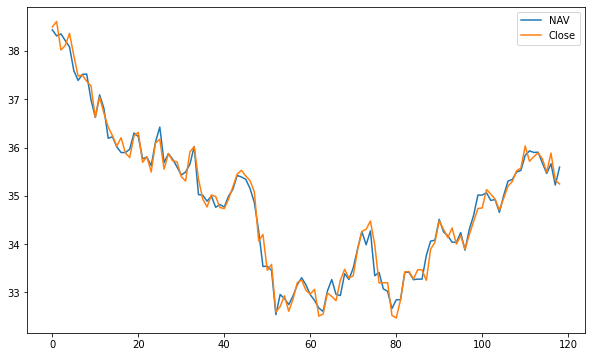

In [40]:
# Plot a time series of the nav and close over time
sesg[['NAV', 'Close']].plot(figsize=(10, 6))
plt.show()

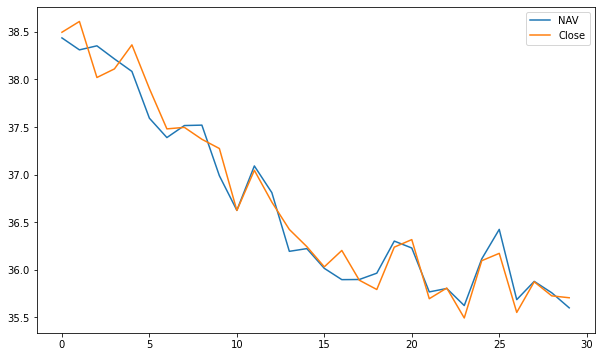

In [41]:
# Plot the nav and close for the last 30 days
sesg[['NAV', 'Close']].tail(30).plot(figsize=(10, 6))
plt.show()

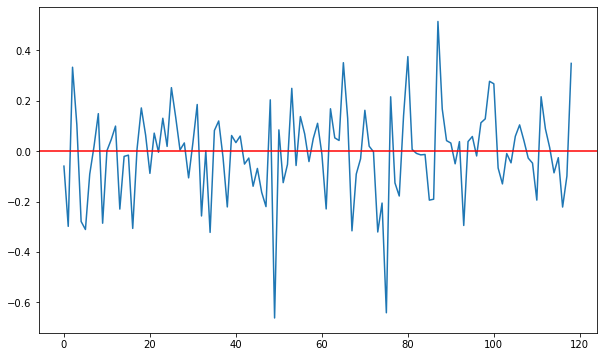

In [94]:
# Plot the premium/discount between the NAV and Close
sesg['Premium/Discount'] = sesg['NAV'] - sesg['Close']
sesg['Premium/Discount'].plot(figsize=(10, 6))
plt.axhline(0, color='red')
plt.show()

In [89]:
spread = sesg['Premium/Discount']
spreadmean = spread.mean()
spreadstd = spread.std()
df = sesg
df['zscore'] = (spread - spreadmean) / spreadstd
df['positions_SESG_Long'] = 0
df['positions_NAV_Long'] = 0
df['positions_SESG_Short'] = 0
df['positions_NAV_Short'] = 0

# Short spread
df.loc[df.zscore >= 1.5, ('positions_SESG_Short', 'positions_NAV_Short')] = [-1, 1]
# Exit Short spread
df.loc[df.zscore <= 1, ('positions_SESG_Short', 'positions_NAV_Short')] = 0
# Long spread
df.loc[df.zscore <= -1.5, ('positions_SESG_Long', 'positions_NAV_Long')] = [1, -1]
# Exit Long spread
df.loc[df.zscore >= -1, ('positions_SESG_Long', 'positions_NAV_Long')] = 0
df.head()

,Date,Close,NAV,Premium/Discount,zscore,positions_SESG_Long,positions_NAV_Long,positions_SESG_Short,positions_NAV_Short
118,2022-08-02,35.2465,35.5946,0.3481,1.954157,0,0,-1,1
117,2022-08-03,35.3231,35.2244,-0.0987,-0.488956,0,0,0,0
116,2022-08-04,35.8850,35.6631,-0.2219,-1.162617,0,0,0,0
115,2022-08-05,35.4899,35.4638,-0.0261,-0.091978,0,0,0,0
114,2022-08-08,35.7650,35.6789,-0.0861,-0.420059,0,0,0,0


In [90]:
# Ensures that existing positions are carried forward unless there is an exit signal
df.fillna(method='ffill', inplace=True)

In [115]:
positions_Long = df.loc[:, ['positions_SESG_Long', 'positions_NAV_Long']]
positions_Short = df.loc[:, ['positions_SESG_Short', 'positions_NAV_Short']]
positions = np.array(positions_Long) + np.array(positions_Short)
positions = pd.DataFrame(positions, columns=['SESG', 'NAV'], index=sesg['Date'])
positions.head(20)

,SESG,NAV
Date,,
2022-08-02,-1,1
2022-08-03,0,0
2022-08-04,0,0
2022-08-05,0,0
2022-08-08,0,0
2022-08-09,0,0
2022-08-10,0,0
2022-08-11,0,0
2022-08-12,0,0


The series is obviously stationary, now it is a matter of isolating a security with a close to 1 beta with the NAV or determining if it is profitable to only trade the ETF.

In [53]:
# Get the yfinance data for GLD for the same dates in the SESG dataset
gld = yf.download('GLD', '2022-08-02', '2023-01-20')
gld.reset_index(inplace=True)
gld.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
113,2023-01-12,176.009995,176.710007,174.880005,176.639999,176.639999,6936900
114,2023-01-13,176.960007,178.830002,176.889999,178.759995,178.759995,7455100
115,2023-01-17,178.210007,178.240005,177.089996,177.589996,177.589996,6610800
116,2023-01-18,178.919998,179.179993,176.899994,177.080002,177.080002,5384700
117,2023-01-19,178.369995,180.029999,178.089996,179.889999,179.889999,6678700


In [55]:
nav_df = sesg[['Date', 'NAV']]
# Drop the last day in the nav_df
nav_df = nav_df[:-1]
gld_df = gld[['Date', 'Adj Close']]
print(f'nav days: {len(nav_df)}, gld days: {len(gld_df)}')

nav days: 118, gld days: 118


In [58]:
# Calculate the beta between the two time series
covariance = nav_df['NAV'].pct_change().cov(gld['Adj Close'].pct_change())
variance = gld['Adj Close'].pct_change().var()
beta = covariance / variance
print(beta)

-0.1860749402074213


Now determining if it is profitable to use the nav as a proxy for the true value of the ETF.

Short the ETF when the market price has statistically deviated too high from the NAV, long the ETF when the market price has become too cheap against the nav.

In [67]:
# Make a df of the premium/discount of the NAV to the Close of sesg
prmd = pd.DataFrame()
prmd['Premium/Discount'] = sesg['NAV'] - sesg['Close']
# Add the dates
prmd = pd.DataFrame(prmd)
prmd['Date'] = sesg['Date']
prmd.head()

,Premium/Discount,Date
118,0.3481,2022-08-02
117,-0.0987,2022-08-03
116,-0.2219,2022-08-04
115,-0.0261,2022-08-05
114,-0.0861,2022-08-08


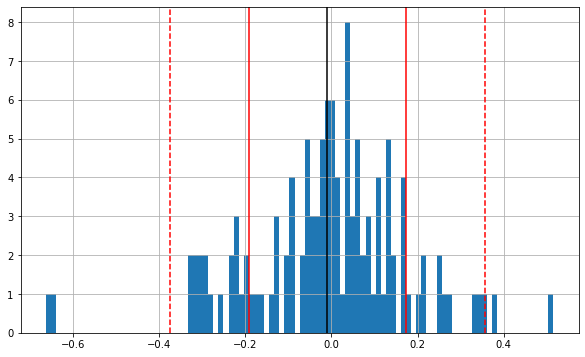

In [72]:
# Plot the distribution of the premium/discount
prmd['Premium/Discount'].hist(bins=100, figsize=(10, 6))
plt.axvline(prmd['Premium/Discount'].mean(), color='black')
plt.axvline(prmd['Premium/Discount'].mean() + prmd['Premium/Discount'].std(), color='red')
plt.axvline(prmd['Premium/Discount'].mean() - prmd['Premium/Discount'].std(), color='red')
plt.axvline(prmd['Premium/Discount'].mean() + 2 * prmd['Premium/Discount'].std(), color='red', linestyle='--')
plt.axvline(prmd['Premium/Discount'].mean() - 2 * prmd['Premium/Discount'].std(), color='red', linestyle='--')
plt.show()

In [73]:
# Calculate 1, 1.5, and 2 standard deviations from the mean
mean = prmd['Premium/Discount'].mean()
std = prmd['Premium/Discount'].std()
one_std = mean + std
one_half_std = mean + 1.5 * std
two_std = mean + 2 * std
print(f'1 std: {one_std}, 1.5 std: {one_half_std}, 2 std: {two_std}')

1 std: 0.17360239437407077, 1.5 std: 0.2650430873594256, 2 std: 0.3564837803447804


In [78]:
# Find the dates where the premium/discount is greater than 1, 1.5, and 2 standard deviations from the mean in separate lists
one_std_dates = []
one_half_std_dates = []
two_std_dates = []
for i in range(len(prmd)):
    if prmd['Premium/Discount'][i] > one_std:
        one_std_dates.append(prmd['Date'][i])
    if prmd['Premium/Discount'][i] > one_half_std:
        one_half_std_dates.append(prmd['Date'][i])
    if prmd['Premium/Discount'][i] > two_std:
        two_std_dates.append(prmd['Date'][i])
print(f'1 std dates: {one_std_dates}')
print(f'1.5 std dates: {one_half_std_dates}')
print(f'2 std dates: {two_std_dates}')
print(str(len(one_half_std_dates) + len(two_std_dates) + len(one_std_dates)), "trades")

1 std dates: [Timestamp('2023-01-18 00:00:00'), Timestamp('2022-12-13 00:00:00'), Timestamp('2022-12-05 00:00:00'), Timestamp('2022-11-09 00:00:00'), Timestamp('2022-11-02 00:00:00'), Timestamp('2022-10-17 00:00:00'), Timestamp('2022-09-30 00:00:00'), Timestamp('2022-09-26 00:00:00'), Timestamp('2022-09-15 00:00:00'), Timestamp('2022-08-29 00:00:00'), Timestamp('2022-08-26 00:00:00'), Timestamp('2022-08-11 00:00:00'), Timestamp('2022-08-02 00:00:00')]
1.5 std dates: [Timestamp('2023-01-18 00:00:00'), Timestamp('2022-10-17 00:00:00'), Timestamp('2022-09-26 00:00:00'), Timestamp('2022-09-15 00:00:00'), Timestamp('2022-08-29 00:00:00'), Timestamp('2022-08-26 00:00:00'), Timestamp('2022-08-02 00:00:00')]
2 std dates: [Timestamp('2022-09-26 00:00:00'), Timestamp('2022-09-15 00:00:00')]
22 trades
